.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


[Phase 0] Running Unit Tests...
--- Running Advanced Waterfall (Z-Bond + Triggers) ---
--- Optimizing Portfolio (Target: $500,000,000) ---
--- Loading Real Tape: /media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/combined_performance_history_2017_2020.csv ---
--- Processing Cash Flows & Credit Metrics (Cut-Off: 2019-01-01) ---

[Phase 1] Structuring Seasoned Deal (Bal: $458.5MM)
--- Running Advanced Waterfall (Z-Bond + Triggers) ---

Tranche    | Type       | Curr Bal     | Factor   | Cum Loss  
-----------------------------------------------------------------
Class A    | Sequential | $0.0      MM | 0.0000   | $0
Class B    | Support    | $0.0      MM | 0.0000   | $0
Class Z    | Accrual_Z  | $47.7     MM | 1.0392   | $0

[Phase 2] Stochastic Valuation Check
   Generated 100 Interest Rate Paths using Vol Surface.
   Sample Path End Rates: 8.13%, 1.56%

Chart saved as 'advanced_mbs_backtest.png'


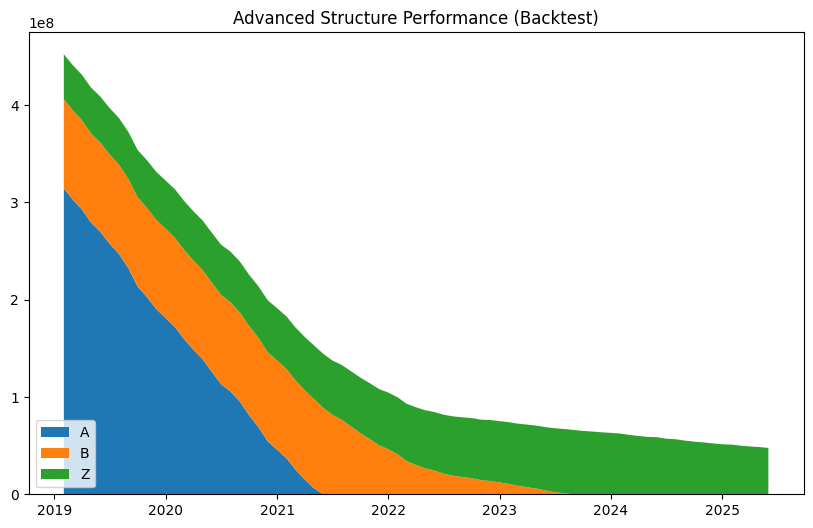

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import unittest
import warnings
from scipy.interpolate import RegularGridInterpolator

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# MODULE 1: DATA INGESTION & POOLING (Collateral Manager)
# =============================================================================
class LoanPool:
    def __init__(self, dataframe, name="Generic Pool"):
        self.name = name
        self.data = dataframe.copy()
        self._validate_and_clean()

    def _validate_and_clean(self):
        required_cols = ['ORIGINAL_UPB', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_LOAN_TERM', 'LOAN_SEQUENCE_NUMBER', 'FIRST_PAYMENT_DATE']
        self.data = self.data.dropna(subset=required_cols)
        
        # Normalize Interest Rate
        if self.data['ORIGINAL_INTEREST_RATE'].mean() > 1:
            self.data['ORIGINAL_INTEREST_RATE'] = self.data['ORIGINAL_INTEREST_RATE'] / 100.0
            
        self.data['ORIGINAL_UPB'] = self.data['ORIGINAL_UPB'].astype(float)
        self.data['ORIGINAL_LOAN_TERM'] = self.data['ORIGINAL_LOAN_TERM'].astype(int)
        self.data['LOAN_SEQUENCE_NUMBER'] = self.data['LOAN_SEQUENCE_NUMBER'].astype(str)

    def get_stats(self):
        total_upb = self.data['ORIGINAL_UPB'].sum()
        wac = (self.data['ORIGINAL_INTEREST_RATE'] * self.data['ORIGINAL_UPB']).sum() / total_upb if total_upb > 0 else 0
        return len(self.data), total_upb, wac

class PortfolioOptimizer:
    def __init__(self, loan_pool):
        self.universe = loan_pool.data.copy()
        
    def construct_portfolio(self, target_upb, constraints):
        print(f"--- Optimizing Portfolio (Target: ${target_upb:,.0f}) ---")
        self.universe['Score'] = self.universe['ORIGINAL_INTEREST_RATE']
        sorted_universe = self.universe.sort_values('Score', ascending=False)
        selected = []
        curr_upb = 0
        state_counts = {}
        
        for idx, row in sorted_universe.iterrows():
            if curr_upb >= target_upb: break
            state = row['PROPERTY_STATE']
            conc = state_counts.get(state, 0) / (curr_upb + 1e-9)
            if conc > constraints.get('max_state_concentration', 1.0): continue
            selected.append(idx)
            curr_upb += row['ORIGINAL_UPB']
            state_counts[state] = state_counts.get(state, 0) + row['ORIGINAL_UPB']
            
        return LoanPool(self.universe.loc[selected], name="Optimized Pool")

# =============================================================================
# MODULE 2: SURVEILLANCE ENGINE (Real Data + Credit Metrics)
# =============================================================================
class SurveillanceEngine:
    def __init__(self, loan_pool):
        self.pool_ids = set(loan_pool.data['LOAN_SEQUENCE_NUMBER'])
        self.pool_data = loan_pool.data
        
    def load_performance_data(self, file_path, use_synthetic=False):
        if not use_synthetic and file_path and os.path.exists(file_path):
            print(f"--- Loading Real Tape: {file_path} ---")
            # Try to load credit columns
            cols = ['LOAN_SEQUENCE_NUMBER', 'MONTHLY_REPORTING_PERIOD', 'CURRENT_ACTUAL_UPB', 
                    'CURRENT_INTEREST_RATE', 'CURRENT_LOAN_DELINQUENCY_STATUS', 'ACTUAL_LOSS_CALCULATION']
            try:
                tape = pd.read_csv(file_path, sep='|', usecols=cols)
            except ValueError:
                print("   [Warn] Advanced credit columns missing in CSV. Loading basic columns.")
                cols = ['LOAN_SEQUENCE_NUMBER', 'MONTHLY_REPORTING_PERIOD', 'CURRENT_ACTUAL_UPB', 'CURRENT_INTEREST_RATE']
                tape = pd.read_csv(file_path, sep='|', usecols=cols)
                tape['CURRENT_LOAN_DELINQUENCY_STATUS'] = '0'
                tape['ACTUAL_LOSS_CALCULATION'] = 0.0

            tape = tape[tape['LOAN_SEQUENCE_NUMBER'].isin(self.pool_ids)].copy()
        else:
            print("--- Generating Synthetic Tape (Fallback) ---")
            tape = self._generate_synthetic()
        
        tape['Date'] = pd.to_datetime(tape['MONTHLY_REPORTING_PERIOD'].astype(str), format='%Y%m')
        tape = tape.sort_values(['LOAN_SEQUENCE_NUMBER', 'Date'])
        return tape

    def process_monthly_cashflows(self, tape_df, cut_off_date=None):
        print(f"--- Processing Cash Flows & Credit Metrics (Cut-Off: {cut_off_date}) ---")
        
        # 1. Calc Flows
        tape_df['Prev_UPB'] = tape_df.groupby('LOAN_SEQUENCE_NUMBER')['CURRENT_ACTUAL_UPB'].shift(1)
        tape_df['TOTAL_DROP'] = (tape_df['Prev_UPB'] - tape_df['CURRENT_ACTUAL_UPB']).clip(lower=0)
        tape_df['INTEREST_PAID'] = tape_df['Prev_UPB'] * (tape_df['CURRENT_INTEREST_RATE'] / 1200.0)
        
        # 2. Extract Credit Metrics
        tape_df['DQ_Numeric'] = pd.to_numeric(tape_df['CURRENT_LOAN_DELINQUENCY_STATUS'], errors='coerce').fillna(0)
        tape_df['Is_Delinquent'] = tape_df['DQ_Numeric'] > 0 
        tape_df['Realized_Loss'] = pd.to_numeric(tape_df.get('ACTUAL_LOSS_CALCULATION', 0), errors='coerce').fillna(0)
        
        # 3. Derive Principal Cash (Net of Losses)
        tape_df['PRINCIPAL_CASH'] = (tape_df['TOTAL_DROP'] - tape_df['Realized_Loss']).clip(lower=0)

        tape_df = tape_df.dropna(subset=['Prev_UPB'])

        # 4. Seasoning Logic
        start_bal = 0
        if cut_off_date:
            dt = pd.to_datetime(cut_off_date)
            per = int(dt.strftime('%Y%m'))
            at_cutoff = tape_df[tape_df['MONTHLY_REPORTING_PERIOD'] == per]
            start_bal = at_cutoff['CURRENT_ACTUAL_UPB'].sum()
            tape_df = tape_df[tape_df['Date'] > dt]
        else:
            start_bal = self.pool_data['ORIGINAL_UPB'].sum()

        # 5. Aggregate to Pool Level
        pool_cf = tape_df.groupby('Date').agg({
            'INTEREST_PAID': 'sum', 
            'PRINCIPAL_CASH': 'sum',
            'Realized_Loss': 'sum',
            'Is_Delinquent': 'sum',
            'LOAN_SEQUENCE_NUMBER': 'count'
        }).rename(columns={'LOAN_SEQUENCE_NUMBER': 'Active_Count'}).reset_index()

        pool_cf['DQ_Rate'] = pool_cf['Is_Delinquent'] / pool_cf['Active_Count']
        
        return pool_cf, start_bal

    def _generate_synthetic(self):
        rows = []
        months = pd.period_range('2017-01', '2020-12', freq='M')
        for _, loan in self.pool_data.iterrows():
            upb, rate, term = loan['ORIGINAL_UPB'], loan['ORIGINAL_INTEREST_RATE'], loan['ORIGINAL_LOAN_TERM']
            try: start = pd.Period(str(loan['FIRST_PAYMENT_DATE']), freq='M')
            except: continue
            r_m = rate/12.0
            pmt = upb*(r_m*(1+r_m)**term)/((1+r_m)**term-1) if r_m>0 else upb/term
            curr = upb
            for m in months:
                if m < start: continue
                if curr <= 0: break
                
                is_dq = 1 if np.random.random() < 0.01 else 0
                inte = curr * r_m
                prin = pmt - inte
                smm = 0.002 if np.random.random() > 0.005 else 1.0
                curr = max(0, curr - prin - (curr-prin)*smm)
                
                rows.append({
                    'LOAN_SEQUENCE_NUMBER': loan['LOAN_SEQUENCE_NUMBER'], 
                    'MONTHLY_REPORTING_PERIOD': int(m.strftime('%Y%m')), 
                    'CURRENT_ACTUAL_UPB': curr, 
                    'CURRENT_INTEREST_RATE': rate*100,
                    'CURRENT_LOAN_DELINQUENCY_STATUS': str(is_dq),
                    'ACTUAL_LOSS_CALCULATION': 0.0
                })
        return pd.DataFrame(rows)

# =============================================================================
# MODULE 3: MARKET & VALUATION (Volatility Surface & Quant Engine)
# =============================================================================
class VolatilitySurface:
    def __init__(self):
        self.expiries = [1, 2, 5, 10, 30]
        self.tenors = [1, 2, 5, 10, 30]
        # Mock Surface: Higher short-term vol, lower long-term
        self.vol_grid = np.array([
            [0.0120, 0.0130, 0.0140, 0.0150, 0.0145],
            [0.0125, 0.0135, 0.0145, 0.0155, 0.0150],
            [0.0130, 0.0140, 0.0150, 0.0160, 0.0155],
            [0.0110, 0.0120, 0.0130, 0.0140, 0.0135],
            [0.0090, 0.0100, 0.0110, 0.0120, 0.0115],
        ])
        self.interpolator = RegularGridInterpolator((self.expiries, self.tenors), self.vol_grid, bounds_error=False, fill_value=None)

    def get_volatility(self, expiry, tenor=10):
        return float(self.interpolator((expiry, tenor)))

class QuantEngine:
    def __init__(self, start_rate, vol_surface):
        self.r0 = start_rate
        self.vol_surface = vol_surface
        
    def generate_rate_paths(self, n_paths, n_months):
        dt = 1/12.0
        paths = np.zeros((n_paths, n_months))
        paths[:, 0] = self.r0
        for t in range(1, n_months):
            sigma = self.vol_surface.get_volatility(expiry=t/12.0)
            shock = np.random.normal(0, np.sqrt(dt), n_paths)
            paths[:, t] = np.maximum(paths[:, t-1] + (sigma * shock), 0.0)
        return paths

# =============================================================================
# MODULE 4: ADVANCED STRUCTURING ENGINE (The Waterfall)
# =============================================================================
class Tranche:
    def __init__(self, name, balance, coupon, tranche_type="Sequential"):
        self.name = name
        self.original_balance = balance
        self.current_balance = balance
        self.coupon = coupon
        self.tranche_type = tranche_type 
        self.cumulative_loss = 0.0
        self.history = {'Balance': [], 'Interest': [], 'Principal': [], 'Loss': []}

class AdvancedStructuringEngine:
    def __init__(self, tranches):
        self.tranches = tranches
        
    def run_waterfall(self, pool_cfs):
        print("--- Running Advanced Waterfall (Z-Bond + Triggers) ---")
        
        for _, row in pool_cfs.iterrows():
            avail_int = row.get('INTEREST_PAID', 0)
            avail_prin = row.get('PRINCIPAL_CASH', 0)
            period_loss = row.get('Realized_Loss', 0)
            dq_rate = row.get('DQ_Rate', 0)
            
            payouts = {t.name: {'Int': 0.0, 'Prin': 0.0, 'Loss': 0.0} for t in self.tranches}
            
            # 1. TRIGGER CHECK
            is_trigger = dq_rate > 0.05 
            
            # 2. INTEREST & ACCRETION
            accrual_pot = 0.0
            for t in self.tranches:
                if t.current_balance <= 0: continue
                int_due = t.current_balance * (t.coupon / 12.0)
                
                if t.tranche_type == 'Accrual_Z':
                    t.current_balance += int_due # Accrete
                    accrual_pot += int_due
                    payouts[t.name]['Int'] = 0.0
                elif is_trigger and t.tranche_type == 'Support':
                    accrual_pot += int_due # Divert
                    payouts[t.name]['Int'] = 0.0
                else:
                    pay = min(avail_int, int_due)
                    avail_int -= pay
                    payouts[t.name]['Int'] = pay
            
            # 3. PRINCIPAL (Sequential + Turbo)
            total_prin = avail_prin + accrual_pot
            for t in self.tranches:
                if total_prin <= 0 or t.current_balance <= 0: continue
                pay = min(t.current_balance, total_prin)
                t.current_balance -= pay
                total_prin -= pay
                payouts[t.name]['Prin'] = pay
                
            # 4. LOSS ALLOCATION
            rem_loss = period_loss
            for t in reversed(self.tranches):
                if rem_loss <= 0 or t.current_balance <= 0: continue
                writedown = min(t.current_balance, rem_loss)
                t.current_balance -= writedown
                t.cumulative_loss += writedown
                rem_loss -= writedown
                payouts[t.name]['Loss'] = writedown

            # 5. COMMIT
            for t in self.tranches:
                t.history['Interest'].append(payouts[t.name]['Int'])
                t.history['Principal'].append(payouts[t.name]['Prin'])
                t.history['Loss'].append(payouts[t.name]['Loss'])
                t.history['Balance'].append(t.current_balance)
                
        return self.tranches

# =============================================================================
# MODULE 5: UNIT TESTS
# =============================================================================
class TestMBSLogic(unittest.TestCase):
    def setUp(self):
        self.t_a = Tranche("A", 100, 0.03, "Sequential")
        self.t_z = Tranche("Z", 10, 0.05, "Accrual_Z")
        self.engine = AdvancedStructuringEngine([self.t_a, self.t_z])
        
    def test_z_bond_accretion(self):
        """Test if Class A gets 'Turbo' principal from Z's interest"""
        row = {'INTEREST_PAID': 100, 'PRINCIPAL_CASH': 0, 'Realized_Loss': 0, 'DQ_Rate': 0}
        df = pd.DataFrame([row])
        self.engine.run_waterfall(df)
        self.assertTrue(self.t_z.current_balance > 10.0, "Z did not accrete")
        self.assertTrue(self.t_a.history['Principal'][0] > 0, "A did not get Turbo")

# =============================================================================
# MAIN EXECUTION
# =============================================================================
def main():
    DATA_DIR = "/media/hansheng/cc7df9bc-e728-4b8d-a215-b64f31876acc/cdo-tee-mock/prepayment/data/Extracted_data/"
    STATIC = DATA_DIR + 'combined_sampled_mortgages_2017_2020.csv'
    PERF = DATA_DIR +'combined_performance_history_2017_2020.csv'
    CUT_OFF = '2019-01-01'
    
    # 1. RUN UNIT TESTS
    print("[Phase 0] Running Unit Tests...")
    suite = unittest.TestLoader().loadTestsFromTestCase(TestMBSLogic)
    unittest.TextTestRunner(verbosity=1).run(suite)
    
    # 2. REAL DATA LOAD
    try: raw = pd.read_csv(STATIC, sep='|')
    except: print("Missing static file."); return
    
    # Filter for Cut-Off
    cut_int = int(pd.to_datetime(CUT_OFF).strftime('%Y%m'))
    master = LoanPool(raw)
    valid_data = master.data[master.data['FIRST_PAYMENT_DATE'] <= cut_int]
    valid_pool = LoanPool(valid_data)
    
    opt = PortfolioOptimizer(valid_pool)
    deal_pool = opt.construct_portfolio(500_000_000, {'max_state_concentration': 0.20})
    
    # 3. SURVEILLANCE
    surv = SurveillanceEngine(deal_pool)
    use_synth = not os.path.exists(PERF)
    tape = surv.load_performance_data(PERF, use_synthetic=use_synth)
    
    pool_cfs, start_bal = surv.process_monthly_cashflows(tape, cut_off_date=CUT_OFF)
    
    if start_bal == 0: return

    # 4. STRUCTURE DEAL
    print(f"\n[Phase 1] Structuring Seasoned Deal (Bal: ${start_bal/1e6:.1f}MM)")
    # Advanced Structure: Class Z is Accrual, Class B is Support
    t_a = Tranche("Class A", start_bal*0.70, 0.035, "Sequential")
    t_b = Tranche("Class B", start_bal*0.20, 0.055, "Support")
    t_z = Tranche("Class Z", start_bal*0.10, 0.080, "Accrual_Z")
    
    engine = AdvancedStructuringEngine([t_a, t_b, t_z])
    tranches = engine.run_waterfall(pool_cfs)
    
    print(f"\n{'Tranche':<10} | {'Type':<10} | {'Curr Bal':<12} | {'Factor':<8} | {'Cum Loss':<10}")
    print("-" * 65)
    for t in tranches:
        f = t.current_balance / t.original_balance if t.original_balance > 0 else 0
        print(f"{t.name:<10} | {t.tranche_type:<10} | ${t.current_balance/1e6:<9,.1f}MM | {f:.4f}   | ${t.cumulative_loss:,.0f}")

    # 5. STOCHASTIC PRICING (Optional)
    print("\n[Phase 2] Stochastic Valuation Check")
    vol_surf = VolatilitySurface()
    quant = QuantEngine(start_rate=0.045, vol_surface=vol_surf)
    rate_paths = quant.generate_rate_paths(n_paths=100, n_months=360)
    print(f"   Generated {len(rate_paths)} Interest Rate Paths using Vol Surface.")
    print(f"   Sample Path End Rates: {rate_paths[0][-1]*100:.2f}%, {rate_paths[1][-1]*100:.2f}%")

    if len(pool_cfs) > 0:
        plt.figure(figsize=(10,6))
        plt.stackplot(pool_cfs['Date'], 
                      t_a.history['Balance'], t_b.history['Balance'], t_z.history['Balance'],
                      labels=['A','B','Z'])
        plt.title("Advanced Structure Performance (Backtest)")
        plt.legend(loc='lower left')
        plt.savefig('advanced_mbs_backtest.png')
        print("\nChart saved as 'advanced_mbs_backtest.png'")

if __name__ == "__main__":
    main()